# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Geographic Analysis

BrainStation Winter 2023: Data Science

## Introduction

This notebook works through an analysis of geographic data (i.e., elevation and aspect) - looking at its influence on wildfire incidence. We want to see if these features of the landscape can accurately predict when a wildfire will be more likely. The location of study for this project are the Santa Monica Mountains, an east-west trending mountain range.

The dataset consists of a high-density grid that has elevation and aspect data appended to each point. Also added to each point is whether there was a wildfire in that location. The elevation and aspect data are sourced from [USGS EarthExplorer](https://earthexplorer.usgs.gov), using the SRTM dataset. The wildfire data is sourced from the [National Interagency Fire Center](https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/explore?location=39.778749%2C-121.769073%2C11.96). 

This notebook uses the .csv written in the final step from the Perimeters file. The .csv has already been cleaned and ready for further processing and modeling.

Please refer to the visualization notebook to see maps of the field site.

## Initial Setup

### Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [7]:
# import geographic information .CSV

df_original=pd.read_csv('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/shapefiles/joins/layer_combine.csv')
df_original

,elevation,aspect,fire
0,52.0,14.743560,1
1,45.0,21.037510,1
2,45.0,333.434967,1
3,51.0,283.392487,1
4,63.0,229.289154,1
...,...,...,...
19831,22.0,270.000000,0
19832,18.0,59.036243,0
19833,20.0,264.805573,0
19834,17.0,63.434952,0


##### Convert aspect, which is a continuous variable, into a categorical.

First, rename columns.

In [10]:
# rename columns
sm_geo=df_original.copy()

In [11]:
sm_geo['asp_cont']=sm_geo['aspect']

sm_geo['elev_cont']=sm_geo['elevation']

sm_geo

,elevation,aspect,fire,asp_cont,elev_cont
0,52.0,14.743560,1,14.743560,52.0
1,45.0,21.037510,1,21.037510,45.0
2,45.0,333.434967,1,333.434967,45.0
3,51.0,283.392487,1,283.392487,51.0
4,63.0,229.289154,1,229.289154,63.0
...,...,...,...,...,...
19831,22.0,270.000000,0,270.000000,22.0
19832,18.0,59.036243,0,59.036243,18.0
19833,20.0,264.805573,0,264.805573,20.0
19834,17.0,63.434952,0,63.434952,17.0


In [12]:
def degToCompass(num):
    '''
    From https://stackoverflow.com/questions/\
    7490660/converting-wind-direction-in-angles-to-text-words
    
    Takes a value between 0 and 360 and 
    outputs the corresponding compass representation
    '''
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]

degToCompass(355)

'N'

In [13]:
sm_geo['asp_cont']

0         14.743560
1         21.037510
2        333.434967
3        283.392487
4        229.289154
            ...    
19831    270.000000
19832     59.036243
19833    264.805573
19834     63.434952
19835    320.710602
Name: asp_cont, Length: 19836, dtype: float64

In [14]:
# `.apply` the function degToCompass
# to each row in the column thusly:
sm_geo['asp_cat']=sm_geo['asp_cont'].apply(degToCompass)
sm_geo

,elevation,aspect,fire,asp_cont,elev_cont,asp_cat
0,52.0,14.743560,1,14.743560,52.0,NNE
1,45.0,21.037510,1,21.037510,45.0,NNE
2,45.0,333.434967,1,333.434967,45.0,NNW
3,51.0,283.392487,1,283.392487,51.0,WNW
4,63.0,229.289154,1,229.289154,63.0,SW
...,...,...,...,...,...,...
19831,22.0,270.000000,0,270.000000,22.0,W
19832,18.0,59.036243,0,59.036243,18.0,ENE
19833,20.0,264.805573,0,264.805573,20.0,W
19834,17.0,63.434952,0,63.434952,17.0,ENE


In [15]:
sm_geo['asp_cat'].value_counts()

SSE    1717
S      1675
SSW    1468
N      1426
NNE    1394
SE     1318
NNW    1268
NE     1213
SW     1201
ESE    1158
NW     1122
ENE    1066
WSW    1025
E      1002
WNW     895
W       888
Name: asp_cat, dtype: int64

##### Convert elevation, which is a continuous variable, into a categorical.

First, rename columns.

In [16]:
# rename columns

sm_geo['elev_cont']=sm_geo['elevation']
sm_geo=sm_geo.rename({'elevation':'elev_cat'},axis=1)

sm_geo=sm_geo[['asp_cont','asp_cat','elev_cont','elev_cat','fire']]
sm_geo.head(1)

,asp_cont,asp_cat,elev_cont,elev_cat,fire
0,14.74356,NNE,52.0,52.0,1


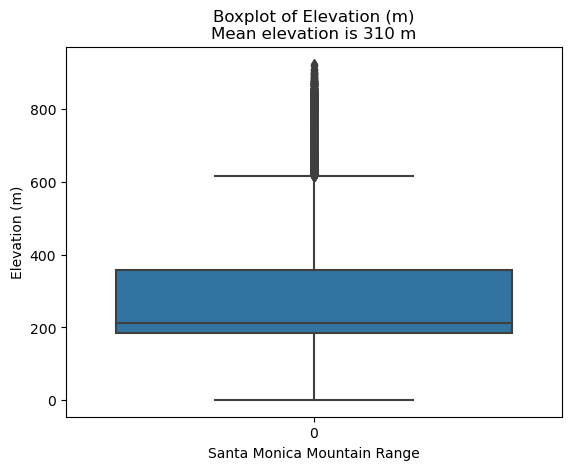

count    19836.000000
mean       281.611867
std        203.469005
min          1.000000
25%        185.000000
50%        212.000000
75%        357.000000
max        924.000000
Name: elev_cont, dtype: float64

In [29]:
chart=sns.boxplot(data=sm_geo['elev_cont'])
chart.set_title('Boxplot of Elevation (m)\nMean elevation is 310 m')
chart.set_ylabel('Elevation (m)')
chart.set_xlabel('Santa Monica Mountain Range')
plt.show()

sm_geo['elev_cont'].describe()

In [18]:
sm_geo.shape

(19836, 5)

I will categorize the elevation into four quartiles:
* $0-25\%$
* $25-50\%$
* $50-75\%$
* $>75\%$

In [33]:
def elevCategorizer(df_col):
    '''
    Hard-codes elevation bins into:
    
    low, medium, high, very high
    3-193, 306-193, 412-306, 917-412
    '''
    
    if df_col <= 193:
        return 'low'
    elif df_col <= 306:
        return 'med'
    elif df_col <= 412:
        return 'high'
    else:
        return 'vhigh'
        
elevCategorizer(450)

'vhigh'

In [34]:
# `.apply` the function elevCategorizer
# to each row in the column thusly:
sm_geo['elev_cat']=sm_geo['elev_cont'].apply(elevCategorizer)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire
0,14.743560,NNE,52.0,low,1
1,21.037510,NNE,45.0,low,1
2,333.434967,NNW,45.0,low,1
3,283.392487,WNW,51.0,low,1
4,229.289154,SW,63.0,low,1
...,...,...,...,...,...
19831,270.000000,W,22.0,low,0
19832,59.036243,ENE,18.0,low,0
19833,264.805573,W,20.0,low,0
19834,63.434952,ENE,17.0,low,0


In [36]:
sm_geo['elev_cat'].value_counts()

med      7868
low      6143
vhigh    4263
high     1562
Name: elev_cat, dtype: int64

Interesting to note that there are more very high elevations than high elevations, and more medium elevations than any other category.

## Prepare data for analysis

#### `get_dummies` on the `asp_cat` column

In [37]:
sm_geo_aspCat=pd.get_dummies(data=sm_geo['asp_cat'])
sm_geo_aspCat

,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19832,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19833,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
19834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_aspCat],axis=1)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire,E,ENE,ESE,N,NE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,14.743560,NNE,52.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.037510,NNE,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,333.434967,NNW,45.0,low,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,283.392487,WNW,51.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,229.289154,SW,63.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,270.000000,W,22.0,low,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19832,59.036243,ENE,18.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19833,264.805573,W,20.0,low,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19834,63.434952,ENE,17.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### `get_dummies` on the `elev_cat` column

In [40]:
# dummies
sm_geo_elevCat=pd.get_dummies(data=sm_geo['elev_cat'])

# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_elevCat],axis=1)

# # reset axis
# sm_geo=sm_geo.reset_index()

# sm_geo=sm_geo.drop(labels=['index','elev_cat','asp_cat'],axis=1)

sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,fire,E,ENE,ESE,N,NE,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,14.743560,NNE,52.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,21.037510,NNE,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,333.434967,NNW,45.0,low,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,283.392487,WNW,51.0,low,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,229.289154,SW,63.0,low,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,270.000000,W,22.0,low,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19832,59.036243,ENE,18.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19833,264.805573,W,20.0,low,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19834,63.434952,ENE,17.0,low,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [326]:
# define X and y

droppedCols=['objectid','perim_id','geometry','fire']

cols=[col for col in sm_geo.columns if col not in droppedCols]

X=sm_geo[cols]
y=sm_geo[['fire']]

X

,asp_cont,elev_cont,E,ENE,ESE,N,NE,NNE,NNW,NW,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,31.883564,434.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7.624194,349.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,72.613029,288.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,335.170654,189.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,346.464142,229.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,149.036240,52.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
18473,185.194427,51.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18474,270.000000,52.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
18475,341.565063,54.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [327]:
print(X.shape)
print(y.shape)

(18477, 22)
(18477, 1)


In [390]:
# reshape the y data into a 1D array for modeling

y_array=np.ravel(a=y,order='C')
y_array.shape

(18477,)

In [329]:
y.sum()/y.count()

fire    0.889809
dtype: float64

The dataset has $89{\%}$ of the landscape enduring a wildfire.

<Axes: >

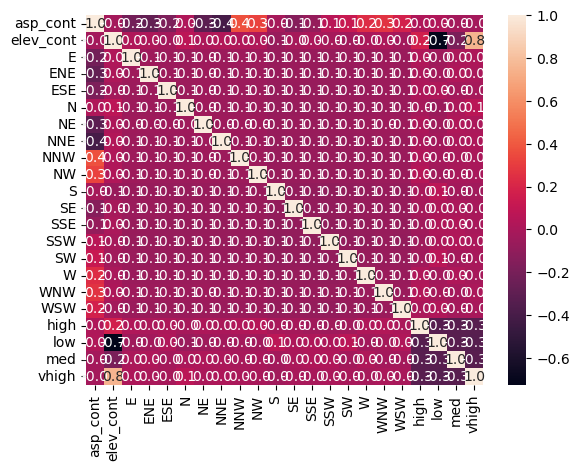

In [330]:
sns.heatmap(data=X.corr(),annot=True, fmt='.1f')

Additionally, there is no collinearity between aspect and elevation.

Areas in the mountains show more of a relationship, though this relationship is very small. This makes sense as areas in the mountains have steeper topography. In the city, where there is less elevation change, the aspect is more random or nonexistant.

## Modeling

### Train, Test, Split

Partition dataset to have $0.\overline3$ of the total as testing.

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=(1/3),stratify=y)

In [332]:
print(f'''
X_train shape: {X_train.shape}\n
y_train shape: {y_train.shape}\n
X_test shape: {X_test.shape}\n
y_test shape: {y_test.shape}
''')


X_train shape: (12318, 22)

y_train shape: (12318,)

X_test shape: (6159, 22)

y_test shape: (6159,)



### Basic logistic regression:

##### `statsmodels`:

In [335]:
# add constant to prepare for statsmodels

X_withconstant=sm.add_constant(X)
X_withconstant.head()

,const,asp_cont,elev_cont,E,ENE,ESE,N,NE,NNE,NNW,...,SSE,SSW,SW,W,WNW,WSW,high,low,med,vhigh
0,1.0,31.883564,434.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,7.624194,349.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,72.613029,288.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,335.170654,189.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1.0,346.464142,229.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [336]:
# instantiate model
logreg_sm=sm.Logit(y,X_withconstant)

# fit the model
logreg_sm_results=logreg_sm.fit()

# summary
logreg_sm_results.summary()

         Current function value: 0.277251
         Iterations: 35


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                18477
Model:                          Logit   Df Residuals:                    18456
Method:                           MLE   Df Model:                           20
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                  0.2008
Time:                        17:17:35   Log-Likelihood:                -5122.8
converged:                      False   LL-Null:                       -6409.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6270   1.91e+06  -3.29e-07      1.000   -3.74e+06    3.74e+06
asp_cont      -0.0013      0.001     -2.072      0.038      -0.003   -7.18e-05
elev_cont      0.0127      0.001     21.036      0.000       0.012       0.014
E             -0.2757        nan        nan        nan         nan         nan
ENE           -0.3167        nan        nan        nan         nan         nan
ESE           -0.3926        nan        nan        nan         nan         nan
N             -0.5724        nan        nan        nan         nan         nan
NE            -0.5240        nan        nan        nan         nan         nan
NNE           -0.4955        nan        nan        nan         nan         nan
NNW           -0.3592        nan        nan        nan         nan         nan
NW             0.0959        nan        nan        nan         nan         nan
S              0.3339        nan        nan        nan         nan         nan
SE             0.0431        nan        nan        nan         nan         nan
SSE            0.2217        nan        nan        nan         nan         nan
SSW            0.2712        nan        nan        nan         nan         nan
SW             0.3809        nan        nan        nan         nan         nan
W              0.2763        nan        nan        nan         nan         nan
WNW            0.1259        nan        nan        nan         nan         nan
WSW            0.5604        nan        nan        nan         nan         nan
high          -0.4253        nan        nan        nan         nan         nan
low            0.5799        nan        nan        nan         nan         nan
med           -0.3758        nan        nan        nan         nan         nan
vhigh         -0.4057        nan        nan        nan         nan         nan
==============================================================================
"""

In [337]:
# make the results from the statsmodels logistic regresion
# into a dataframe to compare betas.
# make sure to raise e to the beta to convert to odds

results=logreg_sm_results.params
col_names=list(X_withconstant.columns)
col_vals=[]

for i in range(len(results)):
    col_vals.append(results[i])
    
results_=list(zip(col_names,col_vals))
results_df=pd.DataFrame(results_,columns=['beta_name','beta_logOdds'])

results_df['beta_odds']=results_df['beta_logOdds'].apply(np.exp)
results_df=results_df.sort_values('beta_odds',ascending=False)
results_df=results_df.reset_index()
results_df=results_df.drop(labels=['index'],axis=1)

results_df

,beta_name,beta_logOdds,beta_odds
0,low,0.579882,1.785827
1,WSW,0.560429,1.751423
2,SW,0.380870,1.463557
3,S,0.333861,1.396350
4,W,0.276345,1.318302
5,SSW,0.271201,1.311538
6,SSE,0.221686,1.248180
7,WNW,0.125864,1.134128
8,NW,0.095893,1.100641
9,SE,0.043083,1.044025


Low elevations (less than or equal to 193 m above sea level) almost 2x more likely to experience fires.

As for aspect, WSW-facing areas are almost 2x more likely to have a fire than other areas. Overall, areas facing west and south are more likely to experience a fire than places facing east or north.

##### `sklearn`:

In [333]:
# instantiate model
logreg=LogisticRegression()

# fit the model
logreg.fit(X_train,y_train)

print('Training Score: ',logreg.score(X_train,y_train))
print('Testing Score:  ',logreg.score(X_test,y_test))

Training Score:  0.8951940250040591
Testing Score:   0.89446338691346


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Good match with the training set, though the accuracy is lower than I'd like; it's nearly the same as the base rate. I'll need to scale the data too. Then it would be good to try using `statsmodels` to see if we can make a stronger statistical understanding about what influences wildfires.

In [345]:
from sklearn.preprocessing import StandardScaler

# add scaler
scaler=StandardScaler()

# fit scaler on train
scaler.fit(X_train)

# transform train data
X_scaled_train=scaler.transform(X_train)
X_scaled_test=scaler.transform(X_test)

# apply scaled data to logreg model
logreg_scaled = LogisticRegression(C=1,
                                   solver='lbfgs',
                                   max_iter=10000)\
.fit(X_scaled_train, y_train)

print('Training Score: ',logreg_scaled.score(X_scaled_train,y_train))
print('Testing Score:  ',logreg_scaled.score(X_scaled_test,y_test))

Training Score:  0.895599935054392
Testing Score:   0.8947881149537262


After applying a scaler, the training score actually decreased very slightly. The testing score increased very slightly.

Let's play around with the hyperparameters to see if the accuracy is higher at a particular value.

First, let's create a validation set from the training set. We'll aim for 80% of our data be relegated towards training and validation, and 20% being relegated towards testing.

In [371]:
print(f'There are {sm_geo.shape[0]} rows in the dataset')

There are 18477 rows in the dataset


In [379]:
rows=sm_geo.shape[0]

testing_size=0.2
val_size=0.3

In [380]:
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, 
                     test_size = testing_size,stratify=y)

X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, 
                     test_size = val_size,stratify=y_remainder)

print(f'Shape of test set:       {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set:      {X_train.shape}')

Shape of test set:       (3696, 22)
Shape of validation set: (4435, 22)
Shape of train set:      (10346, 22)


In [406]:
# flatten y sets to make them 1D arrays

y_remainder_array=y_remainder.values.flatten()
y_test_array=y_test_array.values.flatten()
y_train_array=y_train_array.values.flatten()
y_validation_array=y_validation_array.values.flatten()

y_validation_array.shape

(4435,)

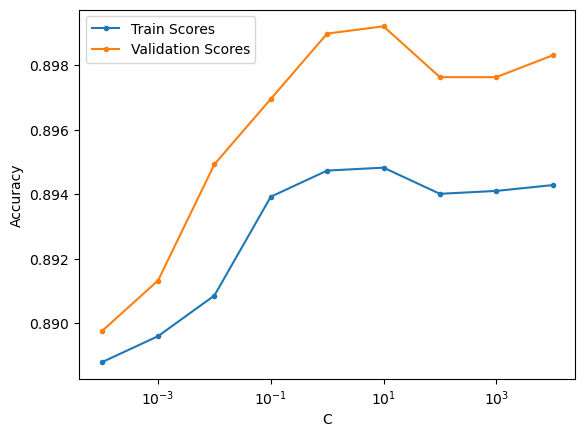

In [417]:
C_range=np.logspace(-4,4,9)

validation_scores=[]
train_scores=[]

for c in C_range:
    tuning_logreg=LogisticRegression(C=c,max_iter=10000)
    tuning_logreg.fit(X_train,y_train.values.flatten())
    
    # train on traning set
    train_scores.\
    append(tuning_logreg.score(X_train,y_train.values.flatten()))
    # score on validation set
    validation_scores.\
    append(tuning_logreg.score(X_validation,y_validation.values.flatten()))

plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It looks like When C is 0.1, we get the best accuracy for the lowest spread between validation and training.

But that's not good enough. Now let's try to increase the accuracy of our model with a grid search. We want to find the best possible accuracy. Let's try to break the 90% mark!

### Grid Search

In [412]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.pipeline import Pipeline

estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('svm', svm.SVC())]
pipe = Pipeline(estimators)

params = {'svm__kernel': ['linear','rbf'], 
          'reduce_dim__n_components': [1, 2, 3]}

grid_search = GridSearchCV(pipe, param_grid=params,verbose=3)
    
fitted_search = grid_search.fit(X_train, y_train.values.flatten())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END reduce_dim__n_components=1, svm__kernel=linear;, score=0.889 total time=   0.3s
[CV 2/5] END reduce_dim__n_components=1, svm__kernel=linear;, score=0.889 total time=   0.3s
[CV 3/5] END reduce_dim__n_components=1, svm__kernel=linear;, score=0.889 total time=   0.2s
[CV 4/5] END reduce_dim__n_components=1, svm__kernel=linear;, score=0.889 total time=   0.3s
[CV 5/5] END reduce_dim__n_components=1, svm__kernel=linear;, score=0.889 total time=   0.3s
[CV 1/5] END reduce_dim__n_components=1, svm__kernel=rbf;, score=0.889 total time=   0.5s
[CV 2/5] END reduce_dim__n_components=1, svm__kernel=rbf;, score=0.889 total time=   0.5s
[CV 3/5] END reduce_dim__n_components=1, svm__kernel=rbf;, score=0.889 total time=   0.4s
[CV 4/5] END reduce_dim__n_components=1, svm__kernel=rbf;, score=0.889 total time=   0.6s
[CV 5/5] END reduce_dim__n_components=1, svm__kernel=rbf;, score=0.889 total time=   0.6s
[CV 1/5] END reduce_dim__